<a href="https://colab.research.google.com/github/dylanh05/pyDFT/blob/master/1DDFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [2]:
class DFT:
    # Space must be a 1D np.linspace and grid is equal length vector of values over the space
    # v_ext is the applied potential to the grid (only supports harmonic oscillator)
    # v_ext = 'harmonic' applies harmonic oscillator to the Hamiltonian
    def __init__(self, space, grid, v_ext):
        self.space = space
        self.grid = grid
        self.v_ext = v_ext

    # Plots the DFT grid on the 1D space it spans
    def plot_grid(self):
        print("DFT grid")
        plt.plot(self.space, self.grid)

    # Plots an arbitrary function on the DFT space, requires self.grid.size == function.size
    def plot_function_over_space(self, function):
        plt.plot(self.space, function)

    # Gets the index of the first occurance of value in the DFT grid
    def get_index(self, value):
        return np.where(self.grid==value)[0][0]

    # Applies NxN operator to 1xN grid
    def linear_operator(self, operator):
        return np.dot(operator, self.grid)

    # Returns finite differences operator for single differentiation
    def deriv(self):
        dx = self.space[1] - self.space[0]
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            if i != self.grid.size-1:
                operator[i][i+1] = -1
                operator[i+1][i] = 1
        operator = operator / (-2* dx)
        return operator

    # Returns finite differences operator for twice differentiation
    def deriv2(self):
        dx = self.space[1] - self.space[0]
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            operator[i][i] = -2
            if i != self.grid.size-1:
                operator[i][i+1] = 1
                operator[i+1][i] = 1
        operator = operator / (dx**2)
        return operator

    # Returns grids of first and second derivatives of grid over the DFT space
    def compute_derivs(self):
        first_derivs = self.linear_operator(self.deriv())
        second_derivs = self.linear_operator(self.deriv2())
        return first_derivs, second_derivs

    # Gives the matrix representation of the kinetic operator applied to function over a grid
    # using the finite difference approximation
    # Approximations can be modified to use numerical differentiation contained within class
    def kinetic_operator(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        for i in range(0, self.grid.size):
            operator[i][i] = 2
            if i != self.grid.size-1:
                operator[i][i+1] = -1
                operator[i+1][i] = -1
        return (1/(2*((self.grid[1] - self.grid[0])**2)))*operator

    # Returns the external potential chosen as a matrix to apply to the hamiltonian
    def external_potential(self):
        operator = np.zeros((self.grid.size, self.grid.size))
        if self.v_ext == "harmonic":
            for i in range(0, self.grid.size):
                operator[i][i] = self.grid[i]
            return operator
        print("External potential chosen: " + str(self.v_ext) + " not yet supported")

    # Uses simple kinetic operator as the diagonalized Hamiltonian and computes Kohm Sham states
    def compute_Kohm_Sham_states(self):
        Hamiltonian = self.kinetic_operator() + self.external_potential()
        epsilon_n, psi_gn = np.linalg.eigh(Hamiltonian)
        return epsilon_n, psi_gn

    # Integrates inputted wavefunction over the DFT grid, return area under curve
    def integrate(self, wavefunction):
        dh = self.space[1]-self.space[0]
        area = 0
        for i in range(0, self.grid.size):
            area += wavefunction[i]*dh
        return area

    # Normalizes all states in psi_gn
    def normalize(self, psi_gn):
        for i in range(self.grid.size):
            area = self.integrate(np.abs(psi_gn[i])**2)
            psi_gn[i] = (np.abs(psi_gn[i])**2)/area
        return psi_gn

    # Plots a state at a given index and the energy associated with it
    def plot_wavefuction(self, epsilon_n, psi_gn, ind):
        print("Energy: " + str(epsilon_n[ind]))
        plt.plot(space, psi_gn[:, ind])
        plt.show()

    # Returns the electron density of the wavefunction for n electrons
    # !!!
    def electron_density(self, psi_gn, n_elec):
        n = np.zeros(self.space.size)
        for i in range(n.size):
            val = 0
            for j in range(n_elec):
                val += j*(psi_gn[j][i]**2)
            n[i] = val
        return n
            

In [3]:
space = np.linspace(0, 10, 500)
print("1D DFT Space: ")
print(space)

1D DFT Space: 
[ 0.       0.02004  0.04008  0.06012  0.08016  0.1002   0.12024  0.14028
  0.16032  0.18036  0.2004   0.22044  0.24048  0.26052  0.28056  0.3006
  0.32064  0.34068  0.36072  0.38076  0.4008   0.42084  0.44088  0.46092
  0.48096  0.501    0.52104  0.54108  0.56112  0.58116  0.6012   0.62124
  0.64128  0.66132  0.68136  0.7014   0.72144  0.74148  0.76152  0.78156
  0.8016   0.82164  0.84168  0.86172  0.88176  0.9018   0.92184  0.94188
  0.96192  0.98196  1.002    1.02204  1.04208  1.06212  1.08216  1.1022
  1.12224  1.14228  1.16232  1.18236  1.2024   1.22244  1.24248  1.26253
  1.28257  1.30261  1.32265  1.34269  1.36273  1.38277  1.40281  1.42285
  1.44289  1.46293  1.48297  1.50301  1.52305  1.54309  1.56313  1.58317
  1.60321  1.62325  1.64329  1.66333  1.68337  1.70341  1.72345  1.74349
  1.76353  1.78357  1.80361  1.82365  1.84369  1.86373  1.88377  1.90381
  1.92385  1.94389  1.96393  1.98397  2.00401  2.02405  2.04409  2.06413
  2.08417  2.10421  2.12425  2.14429  

In [4]:
x = np.random.rand(500)
print("DFT Grid: ")
print(x)

DFT Grid: 
[0.2135  0.10465 0.85056 0.17803 0.18835 0.08145 0.12557 0.19236 0.95366
 0.35858 0.04827 0.21495 0.62039 0.54857 0.33495 0.85577 0.60126 0.51044
 0.81626 0.79985 0.5463  0.33212 0.88561 0.53726 0.98912 0.2447  0.89967
 0.75699 0.52639 0.56181 0.1393  0.17979 0.97746 0.55388 0.92487 0.80829
 0.76787 0.11986 0.53699 0.92196 0.45255 0.4286  0.63331 0.49361 0.1854
 0.89473 0.17574 0.19019 0.2403  0.45486 0.38215 0.56195 0.84856 0.79772
 0.22258 0.25023 0.07114 0.05383 0.87826 0.44661 0.54714 0.71894 0.13565
 0.01698 0.53812 0.46496 0.68167 0.96075 0.76444 0.05448 0.61535 0.5265
 0.27027 0.28836 0.02792 0.48808 0.01521 0.8147  0.70808 0.41657 0.41567
 0.98877 0.10683 0.3146  0.51276 0.34837 0.79908 0.70908 0.23454 0.49049
 0.713   0.65093 0.16035 0.85685 0.09898 0.513   0.00187 0.31144 0.79903
 0.05676 0.24086 0.17258 0.47981 0.31845 0.90591 0.44195 0.423   0.38958
 0.95195 0.33296 0.05252 0.86978 0.17456 0.50187 0.1084  0.64071 0.09502
 0.88904 0.31024 0.97888 0.42069 0.52857 0

DFT grid


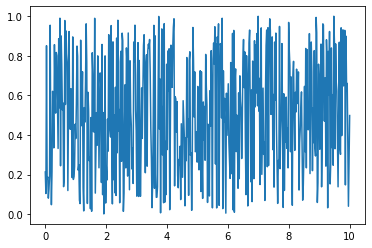

In [5]:
State = DFT(space, x, "harmonic")
State.plot_grid()

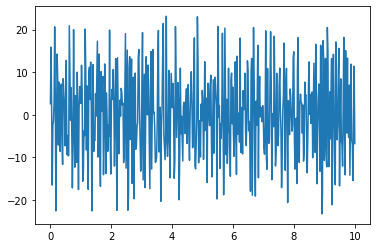

In [6]:
first_derivs, second_derivs = State.compute_derivs()
State.plot_function_over_space(first_derivs)

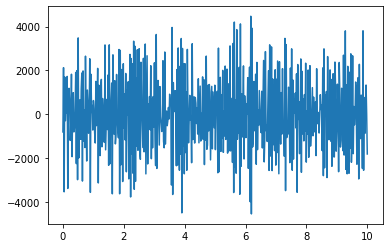

In [7]:
State.plot_function_over_space(second_derivs)

In [8]:
epsilon_n, psi_gn = State.compute_Kohm_Sham_states()

Energy: 0.7188112435392889


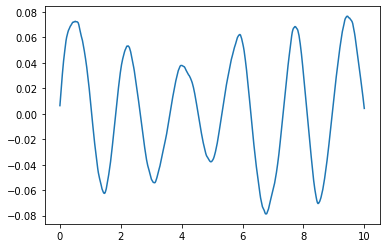

In [9]:
State.plot_wavefuction(epsilon_n, psi_gn, 10)

Energy: 0.7188112435392889


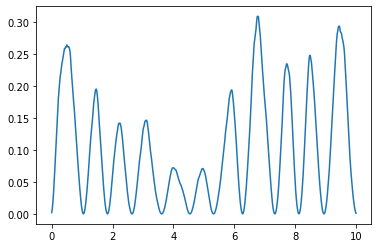

In [10]:
psi_gn = State.normalize(psi_gn)
State.plot_wavefuction(epsilon_n, psi_gn, 10)

In [11]:
print(State.integrate(psi_gn[10]))

0.9999999999999983


In [12]:
n = State.electron_density(psi_gn, 6)

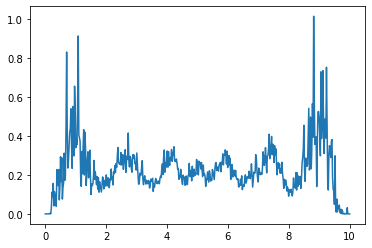

In [13]:
plt.plot(space, n)

In [15]:
print(State.integrate(n))

2.2851557096677326
